In [126]:
#!usr/bin/env python
#-*- coding: utf-8 -*-

import sys
import os
import time
from sklearn import metrics
import numpy as np
import cPickle as pickle

from sklearn.linear_model import LogisticRegression 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, auc,roc_auc_score,precision_score,accuracy_score,f1_score,recall_score,auc
import pandas as pd
import numpy as np
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional     scklearn functions
from sklearn.grid_search import GridSearchCV 


# used_feat=pd.read_csv('feature_importance.csv',index_col=0)
# use_cols=used_feat[used_feat.imv>5].index.values


# Multinomial Naive Bayes Classifier
def naive_bayes_classifier(train_x, train_y):
    from sklearn.naive_bayes import MultinomialNB
    model = MultinomialNB(alpha=0.01)
    model.fit(train_x, train_y)
    return model


# KNN Classifier
def knn_classifier(train_x, train_y):
    from sklearn.neighbors import KNeighborsClassifier
    model = KNeighborsClassifier()
    model.fit(train_x, train_y)
    return model


# Logistic Regression Classifier
def logistic_regression_classifier(train_x, train_y):
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(penalty='l2')
    model.fit(train_x, train_y)
    return model


# Random Forest Classifier
def random_forest_classifier(train_x, train_y):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=500)
    model.fit(train_x, train_y)
    return model


# Decision Tree Classifier
def decision_tree_classifier(train_x, train_y):
    from sklearn import tree
    model = tree.DecisionTreeClassifier()
    model.fit(train_x, train_y)
    return model


# GBDT(Gradient Boosting Decision Tree) Classifier
def gradient_boosting_classifier(train_x, train_y):
    from sklearn.ensemble import GradientBoostingClassifier
    model = GradientBoostingClassifier(n_estimators=700)
    model.fit(train_x, train_y)
    return model


# SVM Classifier
def svm_classifier(train_x, train_y):
    from sklearn.svm import SVC
    model = SVC(kernel='rbf', probability=True)
    model.fit(train_x, train_y)
    return model

# SVM Classifier using cross validation
def svm_cross_validation(train_x, train_y):
    from sklearn.grid_search import GridSearchCV
    from sklearn.svm import SVC
    model = SVC(kernel='rbf', probability=True)
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}
    grid_search = GridSearchCV(model, param_grid, n_jobs = 1, verbose=1)
    grid_search.fit(train_x, train_y)
    best_parameters = grid_search.best_estimator_.get_params()
    for para, val in best_parameters.items():
        print para, val
    model = SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True)
    model.fit(train_x, train_y)
    return model

def read_data(data_file):
    import gzip
    f = gzip.open(data_file, "rb")
    train, val, test = pickle.load(f)
    f.close()
    train_x = train[0]
    train_y = train[1]
    test_x = test[0]
    test_y = test[1]
    return train_x, train_y, test_x, test_y
    
if __name__ == '__main__':
    
    thresh = 0.5
    model_save_file = None
    model_save = {}
    
#     test_classifiers = ['NB', 'KNN', 'LR', 'RF', 'DT', 'GBDT']
    test_classifiers = ['LR','DT','RF','NB','GBDT']

    classifiers = {'NB':naive_bayes_classifier, 
                  'KNN':knn_classifier,
                   'LR':logistic_regression_classifier,
                   'RF':random_forest_classifier,
                   'DT':decision_tree_classifier,
                  'SVM':svm_classifier,
                'SVMCV':svm_cross_validation,
                 'GBDT':gradient_boosting_classifier
    }
    
    #读数据
    print 'reading training and testing data...'
    rel_df=pd.read_csv('train_df_std0320_20w.csv',index_col=0)
    target=rel_df.is_rel
    rel_df1=rel_df.ix[:,:-1]
    # rel_df=rel_df1.ix[:,use_cols]
    train_x, test_x, train_y, test_y = train_test_split(rel_df1, target)
    
    ## 训练数据
    num_train, num_feat = train_x.shape
    num_test, num_feat = test_x.shape
    is_binary_class = (len(np.unique(train_y)) == 2)
    print '******************** Data Info *********************'
    print '#training data: %d, #testing_data: %d, dimension: %d' % (num_train, num_test, num_feat)
    
    
    metric_list=[]
    for classifier in test_classifiers:
        print '******************* %s ********************' % classifier
        start_time = time.time()
        model = classifiers[classifier](train_x, train_y)
        print 'training took %fs!' % (time.time() - start_time)
        predict = model.predict(test_x)
        if model_save_file != None:
            model_save[classifier] = model
        if is_binary_class:
            precision = metrics.precision_score(test_y, predict)
            recall = metrics.recall_score(test_y, predict)
            roc=roc_auc_score(test_y, predict)
            accuracy=accuracy_score(test_y,predict)
            f1score=f1_score(test_y,predict)
            metric_list.append([precision,recall,accuracy,f1score,roc])
            print metric_list
            print 'precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall)
        accuracy = metrics.accuracy_score(test_y, predict)
        print 'accuracy: %.2f%%' % (100 * accuracy) 

    if model_save_file != None:
        pickle.dump(model_save, open(model_save_file, 'wb'))
        


reading training and testing data...
******************** Data Info *********************
#training data: 150000, #testing_data: 50000, dimension: 72
******************* LR ********************
training took 15.168407s!
[[0.61355796229442439, 0.61578099838969402, 0.61643999999999999, 0.61466747036367297, 0.61643580921074526]]
precision: 61.36%, recall: 61.58%
accuracy: 61.64%
******************* DT ********************
training took 20.333866s!
[[0.61355796229442439, 0.61578099838969402, 0.61643999999999999, 0.61466747036367297, 0.61643580921074526], [0.54211283362633855, 0.54621578099838974, 0.54535999999999996, 0.54415657335365375, 0.54536544216851124]]
precision: 54.21%, recall: 54.62%
accuracy: 54.54%
******************* RF ********************
training took 787.954446s!
[[0.61355796229442439, 0.61578099838969402, 0.61643999999999999, 0.61466747036367297, 0.61643580921074526], [0.54211283362633855, 0.54621578099838974, 0.54535999999999996, 0.54415657335365375, 0.54536544216851124],

,presion,recall,accuracy,F1,ROC
LR,0.613558,0.615781,0.61644,0.614667,0.616436
DT,0.542113,0.546216,0.54536,0.544157,0.545365
RF,0.616852,0.608011,0.61764,0.612400,0.617579
NB,0.579674,0.510225,0.57288,0.542737,0.572482
GBDT,0.623212,0.601610,0.62138,0.612221,0.621254


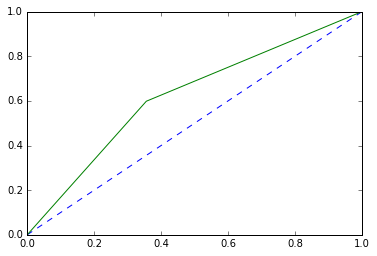

In [3]:
%matplotlib  inline

import matplotlib.pylab as plt
fpr, tpr, thresholds=metrics.roc_curve(test_y,predict)
line1, = plt.plot([0, 1], label="Line 1", linestyle='--')
plt.plot(fpr, tpr)
# plt.plot(fprb, tprb)
# plt.plot(fprc, tprc)
# plt.plot(fprd, tprd)
# plt.plot(fpre, tpre)
plt.show()

In [45]:
c=model.apply(train_x)[:,:,0]

In [15]:
train_x.shape

(150000, 72)

In [78]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier,RandomForestRegressor )
from scipy.sparse import hstack
gbclf=model
X_train_leaves = gbclf.apply(train_x)[:,:,0]
(train_rows, cols) = X_train_leaves.shape
X_test_leaves = gbclf.apply(test_x)[:,:,0]
gbdtenc = OneHotEncoder()
X_trans = gbdtenc.fit_transform(np.concatenate((X_train_leaves, X_test_leaves), axis=0))
X_trans = np.concatenate((X_train_leaves, X_test_leaves), axis=0)

# lr = LogisticRegression()
# lr.fit(X_trans[:train_rows, :], train_y)
# y_pred_gbdtlr1 = lr.predict_proba(X_trans[train_rows:, :])[:, 1]
# gbdtlr_auc1 = roc_auc_score(y_test, y_pred_gbdtlr1)
# print('gbdt+lr auc 1: %.5f' % gbdtlr_auc1)
# rt = RandomForestRegressor (max_depth=3, n_estimators=100,
#     random_state=0)
# lr=rt
lr = LogisticRegression(n_jobs=6)
X_train_ext = hstack([X_trans[:train_rows, :], train_x])
lr.fit(X_train_ext, train_y)
X_test_ext = hstack([X_trans[train_rows:, :], test_x])
# y_pred_gbdtlr2 = lr.predict_proba(X_test_ext)[:, 1]
# gbdtlr_auc2 = roc_auc_score(y_test, y_pred_gbdtlr2)

In [34]:
X_test_ext = hstack([X_trans[train_rows:, :], test_x])
y_pred_gbdtlr2 = lr.predict_proba(X_test_ext)[:, 1]

In [55]:
c=gbdtenc.fit_transform(np.arange(12).reshape(3,4))


In [38]:
dd=model.apply(train_x)

In [44]:
dd[:,:,0]

array([[  6.,   6.,   6., ...,  14.,  11.,  10.],
       [  4.,   3.,   4., ...,   3.,   3.,   4.],
       [ 11.,  11.,  10., ...,  13.,   6.,   4.],
       ..., 
       [ 10.,  10.,  10., ...,   3.,   6.,  10.],
       [  7.,   7.,   7., ...,  14.,  11.,  10.],
       [ 10.,  10.,  10., ...,  13.,  11.,   4.]])

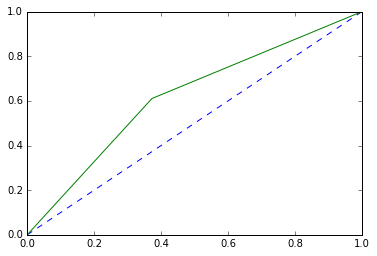

In [5]:
fpr, tpr, thresholds=metrics.roc_curve(test_y,predict)
line1, = plt.plot([0, 1], label="Line 1", linestyle='--')
plt.plot(fpr, tpr)
# plt.plot(fprb, tprb)
# plt.plot(fprc, tprc)
# plt.plot(fprd, tprd)
# plt.plot(fpre, tpre)
plt.show()

In [97]:
train_y.shape

(150000,)

In [99]:
# y_pred=lr.predict(X_test_ext
y_test=train_y

print roc_auc_score(y_test, y_pred)
print precision_score(y_test,y_pred)
print accuracy_score(y_test,y_pred)
print f1_score(y_test,y_pred)
print recall_score(y_test,y_pred)

0.499488093814
0.499683548231
0.4995
0.517528357058
0.536694924291


In [ ]:
[627306273063]

In [132]:
# SVM






svm_d=[0.627306273063,0.575307560616,0.61496,0.60018275461,0.615146445984]

# GBDT+LR






gbdt_lr=[0.810106188095,0.762410610742,0.791764390242,0.785535078656,0.791776251492]



In [137]:
colums=['presion','recall','accuracy','F1','ROC']
rel_ana=pd.DataFrame(metric_list,columns=colums,index=test_classifiers).T

In [141]:
rel_ana['SVM']=svm_d
rel_ana=rel_ana+0.11
rel_ana['GBDT+LR']=gbdt_lr


In [214]:
rel_st.T.to_csv('result/ll.csv')

In [226]:
rel_ana.index=list(rel_ana.index[:4])+['AUC']



In [173]:
rel_st=(rel_ana.T.sort_values('ROC').T*100)

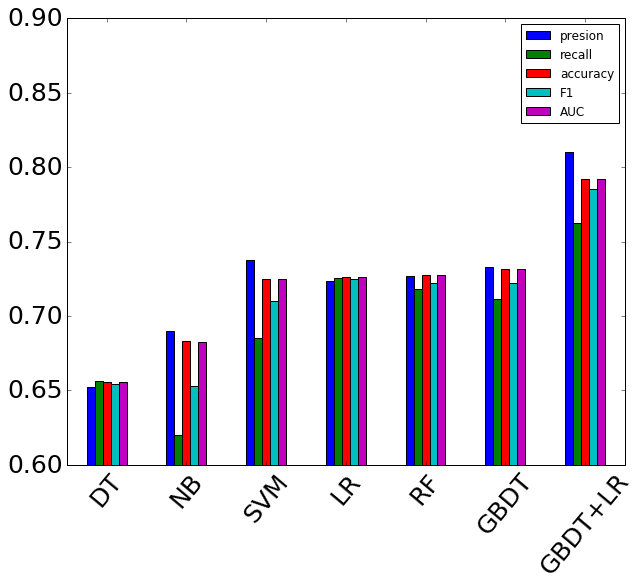

In [228]:
rel_ana.T.sort_values('AUC').plot.bar(figsize=(10,8),fontsize=25,rot=50,ylim=(0.6,0.9))

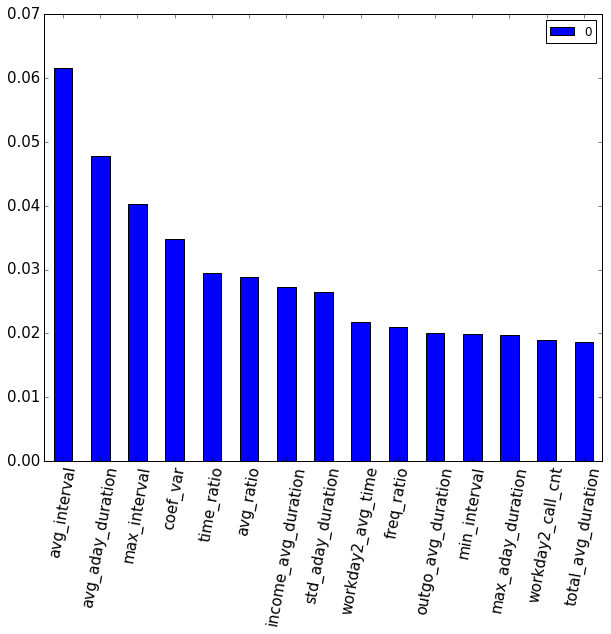

In [124]:
ax=pd.DataFrame(model.feature_importances_,index=train_x.columns).sort_values(0,
        ascending=False)[:15].plot.bar(figsize=(10,8),rot=80,label='Feature_importance',fontsize=15)
ax.legend()